### Importing the required libraries

In [1]:
import pickle
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

### Checking if gpu is availabe

In [2]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A4000


### Loading the dataset

In [3]:
from datasets import load_dataset
dataset = load_dataset('glue', 'mrpc')
dataset

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

### Removing first word

In [4]:
train_s1 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['train']['sentence1']]
train_s2 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['train']['sentence2']]
test_s1 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test']['sentence1']]
test_s2 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in dataset['test']['sentence2']]

### Removing last word

In [27]:
train_s1 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['train']['sentence1']]
train_s2 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['train']['sentence2']]
test_s1 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test']['sentence1']]
test_s2 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in dataset['test']['sentence2']]

### Removing nouns and verbs

In [4]:
import nltk
from nltk import pos_tag

def remove_nouns(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'NN' and pos != 'NNP' and pos != 'NNS']
    return ' '.join(filtered_sentence)

def remove_verbs(sentence):
    words = nltk.word_tokenize(sentence)
    tagged_words = pos_tag(words)
    filtered_sentence = [word for word, pos in tagged_words if pos != 'VB' and pos != 'VBD' and pos != 'VBG' and pos != 'VBN' and pos != 'VBP' and pos != 'VBZ']
    return ' '.join(filtered_sentence)

### Swap words

In [6]:
import nltk
import random
from nltk.tokenize import word_tokenize

def random_swap_words(sentence):
    words = word_tokenize(sentence)
    if len(words) >= 2:
        i, j = random.sample(range(len(words)), 2)
        words[i], words[j] = words[j], words[i]
        return " ".join(words)
    else:
        return sentence

train_s1 = [random_swap_words(sentence) for sentence in dataset['train']['sentence1']]
test_s1 = [random_swap_words(sentence) for sentence in dataset['test']['sentence1']]

train_s2 = [random_swap_words(sentence) for sentence in dataset['train']['sentence2']]
test_s2 = [random_swap_words(sentence) for sentence in dataset['test']['sentence2']]

print("Original Sentences:")
print(dataset['train']['sentence1'][:5])
print("\nRandomly Swapped Sentences:")
print(train_s1[:5])


Original Sentences:
['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .", 'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .', 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .', 'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .']

Randomly Swapped Sentences:
['Amrozi accused his brother , whom he called `` the witness his , of deliberately distorting `` evidence .', "Yucaipa owned Dominick 's before selling the chain to Safeway in billion for $ 2.5 1998 .", 'They had published the advertisement on the Internet on June 10 , offering an cargo for sale , he added .', 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ set , having earlier 4.56 a re

### Add Text

In [4]:
import random
from faker import Faker
from typing import List

def add_random_words(sentences: List[str]):
    fake = Faker()
    new_sentences = []
    for sentence in sentences:
        words = sentence.split()
        num_words_to_add = int(len(words) / 5)
        for i in range(num_words_to_add):
            insert_index = random.randint(0, len(words) - 1)
            words.insert(insert_index, fake.word())
        new_sentences.append(" ".join(words))
    return new_sentences


train_s1 = add_random_words(dataset['train']['sentence1'])
test_s1 = add_random_words(dataset['test']['sentence1'])

train_s2 = add_random_words(dataset['train']['sentence2'])
test_s2 = add_random_words(dataset['test']['sentence2'])

print("Original Sentences:")
print(dataset['train']['sentence1'][:5])
print("\nRandomly Swapped Sentences:")
print(train_s1[:5])


Original Sentences:
['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .", 'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .', 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .', 'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .']

Randomly Swapped Sentences:
['Amrozi family article gas accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', "Yucaipa owned Dominick 's before selling low the pressure chain to Safeway in 1998 for $ 2.5 billion country .", 'They had published measure an advertisement on the alone Internet on June 10 , offering the cargo exactly blood for sale , he added .', 'history other Around wall 0335

### Change Char

In [5]:
import random
import string

def replace_characters(sentence, probability=0.10):
    new_sentence = ""
    for char in sentence:
        if random.random() < probability:
            char = random.choice(string.ascii_letters)
        new_sentence += char
    return new_sentence

train_s1 = [replace_characters(sentence) for sentence in dataset['train']['sentence1']]
test_s1 = [replace_characters(sentence) for sentence in dataset['test']['sentence1']]

train_s2 = [replace_characters(sentence) for sentence in dataset['train']['sentence2']]
test_s2 = [replace_characters(sentence) for sentence in dataset['test']['sentence2']]

print("Original Sentences:")
print(dataset['train']['sentence1'][:5])
print("\nRandomly Swapped Sentences:")
print(train_s1[:5])


Original Sentences:
['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .", 'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .', 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .', 'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .']

Randomly Swapped Sentences:
['AmroziTaccused Uis brother ,Bwdom Le called " thl witness " , ozXdelibBratelq distorting his evimeUce .', 'mEcaipN owned Douinicv ds befqre selling the cLaih to Safeway in 1998 Kor $ 2.5 billion .', 'They haY NublishedUdn Hdvertrsemeut on dhe Intertet on June 10 ,Poffering thG cargo for sale X heFaddeS .', 'Around 0335 GMT , Tab shares fQre Np 19 cents , or 4.4 %N, at Ay$ 4.56 , havzngsearlier sUt a reco

### Bias

In [4]:

def changeGender(str):
    dictionary = {
    "batman": "batwoman", "batwoman": "batman",
    "boy": "girl", "girl": "boy",
    "boyfriend": "girlfriend", "girlfriend": "boyfriend",
    "father": "mother", "mother": "father",
    "husband": "wife", "wife": "husband",
    "he": "she", "she": "he",
    "his": "her", "her": "his",
    "male": "female", "female": "male",
    "man": "woman", "woman": "man",
    "Mr": "Ms", "Mr": "Ms",
    "sir": "madam", "madam": "sir",
    "son": "daughter", "daughter": "son",
    "uncle": "aunt", "aunt": "uncle",
    }

    str = str + ' ' # Append a space at the en
    temp = ""
    ans = ""

    for i in range(len(str)):
        if str[i] != ' ':
            temp += str[i]
        else:
            if temp in dictionary:
                temp = dictionary[temp]

            ans = ans + temp + ' '
            temp = ""

    return ans

train_s1 = [changeGender(sentence) for sentence in dataset['train']['sentence1']]
test_s1 = [changeGender(sentence) for sentence in dataset['test']['sentence1']]

train_s2 = [changeGender(sentence) for sentence in dataset['train']['sentence2']]
test_s2 = [changeGender(sentence) for sentence in dataset['test']['sentence2']]

print("Original Sentences:")
print(dataset['train']['sentence1'][:5])
print("\nRandomly Swapped Sentences:")
print(train_s1[:5])


Original Sentences:
['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .", 'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .', 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .', 'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .']

Randomly Swapped Sentences:
['Amrozi accused her brother , whom she called " the witness " , of deliberately distorting her evidence . ', "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion . ", 'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , she added . ', 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a

### Using the tokenizer from huggingface

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("gchhablani/bert-base-cased-finetuned-mrpc")

### Loading the pre-trained and fine-tuned models from huggingface and moving them to device

In [7]:
preTrainedModel = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels = 2,
                                                      output_attentions = True,
                                                      output_hidden_states = True,)
preTrainedModel.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
fineTunedModel = AutoModelForSequenceClassification.from_pretrained("gchhablani/bert-base-cased-finetuned-mrpc")
fineTunedModel.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Forming dataloaders

In [9]:
tokenised_dataset = tokenizer(train_s1, train_s2,padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['train']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
train_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [9]:
tokenised_dataset = tokenizer(test_s1, test_s2, padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['test']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
test_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### Getting CLS hidden states for all layers [13, number of sampes, 768] to check layer-wise accuracy

In [11]:
def getCLSHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=b_token_type_ids,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i][:,0,:].to("cpu")
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i][:,0,:].to("cpu")
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [ ]:
hiddenStates = getCLSHiddenStates(preTrainedModel, train_dataloader)
preTrainedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
preTrainedCLSHiddenStatesTrain.shape

In [ ]:
hiddenStates = getCLSHiddenStates(preTrainedModel, test_dataloader)
preTrainedCLSHiddenStatesTest = torch.stack(hiddenStates, dim = 0)
preTrainedCLSHiddenStatesTest.shape

In [ ]:
hiddenStates = getCLSHiddenStates(fineTunedModel, train_dataloader)
fineTunedCLSHiddenStatesTrain =  torch.stack(hiddenStates, dim = 0)
fineTunedCLSHiddenStatesTrain.shape

In [ ]:
hiddenStates = getCLSHiddenStates(fineTunedModel, test_dataloader)
fineTunedCLSHiddenStatesTest = torch.stack(hiddenStates, dim = 0)
fineTunedCLSHiddenStatesTest.shape

In [10]:
def getLabels(model, data_loader):
    predictions = []
    for batch in data_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            results = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, return_dict=True)
            logits = results.logits
            pred = torch.argmax(logits, dim = 1)
            predictions.extend(pred.tolist())
    return predictions

In [11]:
import numpy as np
import pandas as pd
predictions = getLabels(fineTunedModel, test_dataloader)
filename = 'fMRPC.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Forming logistic regressions at each layer to find the layer-wise accuracy for pre-trained and fine-tuned model

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

sc_x = StandardScaler()
for i in range(13):
    xtrain = sc_x.fit_transform(preTrainedCLSHiddenStatesTrain[i])
    xtest = sc_x.fit_transform(preTrainedCLSHiddenStatesTest[i])
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label']) 
    
    preTrain_pred=logreg.predict(xtest)
    filename = 'p{0}/MRPC.tsv'.format(i)
    result = pd.DataFrame(preTrain_pred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)
    
    
    xtrain = sc_x.fit_transform(fineTunedCLSHiddenStatesTrain[i]) 
    xtest = sc_x.fit_transform(fineTunedCLSHiddenStatesTest[i])
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label'])
    
    fineTuned_pred=logreg.predict(xtest)
    filename = 'f{0}/MRPC.tsv'.format(i)
    result = pd.DataFrame(fineTuned_pred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)

### Finding the accuracy of the final layer using the classifier of the fine-tuned model

In [20]:
params = list(fineTunedModel.named_parameters())
dense = torch.nn.Linear(768, 768,device=device, bias = True)
activation = torch.nn.Tanh()
dropout = torch.nn.Dropout(p=0.1)
classifier = torch.nn.Linear(in_features=768, out_features=2,  bias = True)
with torch.no_grad():
    dense.weight = params[-4][1]
    dense.bias = params[-3][1]
    classifier.weight = params[-2][1]
    classifier.bias = params[-1][1]

pooled_output = activation(dense(fineTunedCLSHiddenStatesTest[-1,:,:].to('cuda:0')))
dropout_op = dropout(pooled_output)
logits = classifier(dropout_op)
predictions = torch.argmax(logits, dim = 1)

In [21]:
import pandas as pd
predictions = predictions.to('cpu')
filename = 'MRPC.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Obtaining hidden states to find the CKA metric between the pre-trained and fine-tuned model on test dataset

In [22]:
def getHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=b_token_type_ids,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i].to("cpu").mean(dim = 1)
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [23]:
hiddenStates = getHiddenStates(preTrainedModel, test_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_mrpc.pt')
preTrainedHiddenStates.shape

torch.Size([13, 1725, 768])

In [24]:
hiddenStates = getHiddenStates(fineTunedModel, test_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_mrpc.pt')
fineTunedHiddenStates.shape

torch.Size([13, 1725, 768])

In [25]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [26]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 14)
plt.yticks(np.arange(0,13), fontsize = 14)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(str(cka_matrix[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained BERT', fontsize = 17)
plt.xlabel('Fine-tuned BERT', fontsize = 17)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('MRPC_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('MRPC_preTrained_fineTuned.jpg',  bbox_inches='tight')

### STIR

In [3]:
preTrainedHiddenStates = torch.load('preTrainedHiddenStates_mrpc.pt').to(device)
fineTunedHiddenStates  = torch.load('fineTunedHiddenStates_mrpc.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 1725, 768]) torch.Size([13, 1725, 768])


In [4]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [5]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [6]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [7]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [8]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [9]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

In [10]:
STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

In [11]:
STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

In [12]:
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

STIRm2m1: [0.97595215 0.92180616 0.8077332  0.7966042  0.80126756 0.77405804
 0.6209151  0.5554402  0.4581705  0.37801754 0.33431804 0.21810506
 0.13582578]
STIRm1m2: [0.9757375  0.92194366 0.8045967  0.7935533  0.8006107  0.7715808
 0.75050014 0.7444736  0.7143471  0.68393844 0.6623288  0.627191
 0.53317064]
CKA: [0.9999992  0.9996831  0.99616784 0.9917798  0.98344463 0.95521164
 0.8065097  0.6887929  0.5774545  0.46845108 0.42221364 0.3058836
 0.21069463]


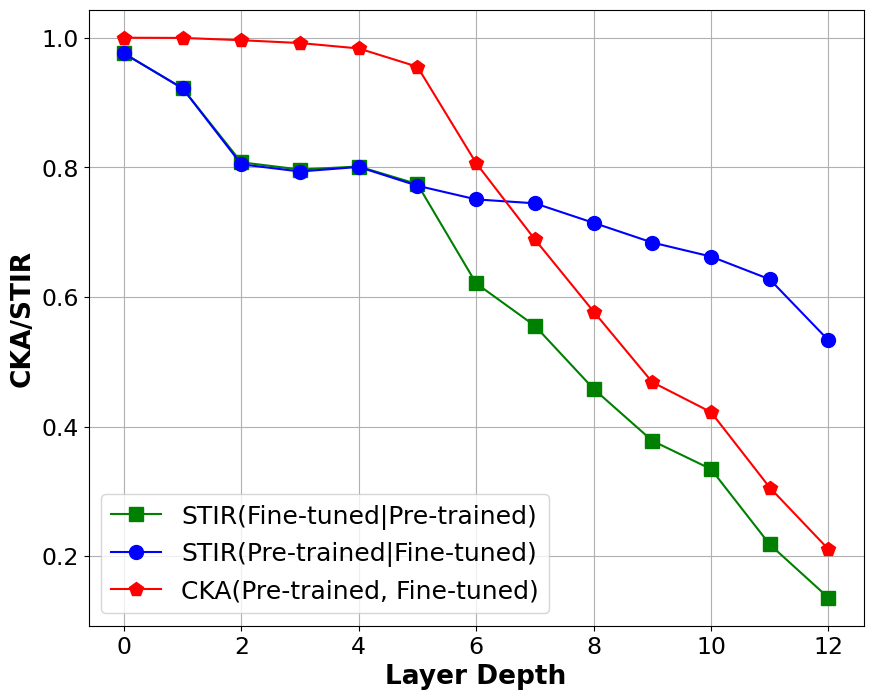

In [2]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=18)
plt.xlabel('Layer Depth', fontsize = 19, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 19, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

#plt.tight_layout()
#plt.show()
plt.savefig('MRPC STIR.pdf', bbox_inches='tight')
plt.savefig('MRPC STIR.jpg', bbox_inches='tight')